# Kaggle's Titanic Starter Competition: 2nd attempt

A first attempt at Kaggle's [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) I got up to 73% accuracy by doing some preprocessing, training with scikit-learn models and submitting.

From [reading around](https://www.quora.com/How-does-one-solve-the-titanic-problem-in-Kaggle) (but not peeking!) it seems that it should be possible to get closer to 80%, and many suspect that those who score much higher are cheating and looking at the full dataset.

So my goal for this follow up notebook is to dig a bit deeper and get above 77% accuracy.

## Candidates for improvement

Some ways I could improve on the first attempt:
- Explore the data to get better intuition
- Include more previously skipped variables
  - Cabin: we could group these by main cabin location (e.g A, B, C, D) in case general location had some influence on e.g how fast folks could get to the life boats.
  - Embarked: could include this in case where people departed from is correlated in some way with survivorship; perhaps those from one location were close knit and had an in on the surival boats? 
- Hyperparameter tuning: we could experiment with some of the available parameters for each model to see if we get better performance against our 30% test set, for instance tree-depth, and regularization parameter C for logistic regression and SVMs

In the first notebook, the fancier models, non-linear SVM and random forests, performed no better than logistic regression. One of the benefits of random forest classifier models is that they don't require much tuning; the randomization step of the ensemble of decision trees each looking at different portions of the variables and training samples provides some automatic tuning. As Python Machine Learning puts it, "We typically don't need to prune the random forest since the ensemble model is quite robust to noise from the individual decision trees."

So if a robust non-linear model performs no better than an untuned logistic regression model, my sense is that fussing with hyperparameter tuning won't get us very far looking at the same variables of the dataset. I think the next best step is to look more closely at the parameters via exploratory analysis and see if it's worth adding in 'Cabin' and/or 'Embarked' and perhaps whether some other parameters could be ignored completely.

## Exploring variables

The first step in exploring the variables of the dataset is to look at each individaully to see what their distributions look like. 


```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```

In [1]:
import pandas as pd

training_data = pd.read_csv('train.csv')

training_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


The dependent variable "surivived" is categorical. Let's do some C->C and Q->C analysis on the categorical output variable, 'survived'.

### Side by side bar charts for categorical features 

For C->C analysis I like side by side bar charts. Let's look at "Pclass", "Sex", and "Embarked". For good measure, we'll intepret the first letter of "Cabin" as another categorical variable.


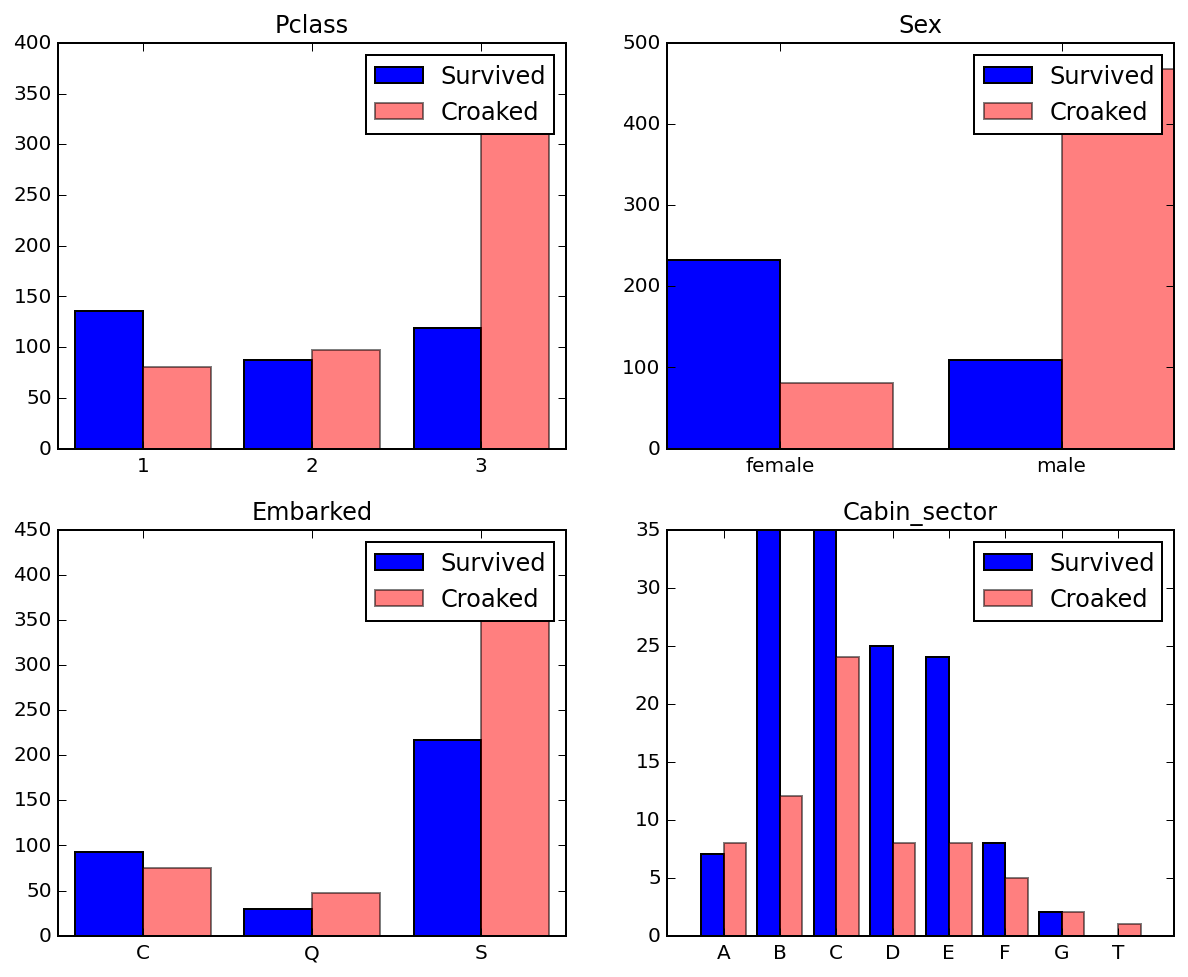

In [4]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

td = training_data
td[['Cabin_sector']] = td[['Cabin']].dropna().applymap(lambda cabin: cabin[0])

def num_survived(var, val):
    return td[var][(td['Survived'] == 1) & (td[var] == val)].count()

def num_croaked(var, val):
    return td[var][(td['Survived'] == 0) & (td[var] == val)].count()

cvars = ['Pclass', 'Sex', 'Embarked', 'Cabin_sector']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

bar_width = 0.4

for i, cvar in enumerate(cvars):
    row = i // 2
    col = i % 2
    subplot = ax[row, col]
    
    all_labels = td[cvar].dropna().unique()
    all_labels.sort()
    bar_locations = np.arange(len(all_labels))
    subplot.bar(
        bar_locations - bar_width,
        [num_survived(cvar, label) for label in all_labels],
        bar_width,
        color='b'
    )
    subplot.bar(
        bar_locations,
        [num_croaked(cvar, label) for label in all_labels],
        bar_width,
        color='r',
        alpha=0.5
    )
    subplot.set_title(cvar)
    subplot.legend(('Survived', 'Croaked'))
    subplot.set_xticks(bar_locations)
    subplot.set_xticklabels(all_labels)    


The variables we used last time, Sex and Pclass both look to have some correlation with surviving, and likely play a role in the success the model had so far in predicting (particularly sex).

It also appears that where the passenger embarked from and what cabin sector also have some correlation with surviving:
- those who depart from Southampton croak disproportinately 
- those who stayed in cabin sectors b, c, d and e survived disproprortionately

So this is promising! Adding in 'Embarked' and 'Cabin_sector' should improve the model.


### Histograms for quantitative features

For Q->C analysis I like overlapping histograms as it gives an idea of . The quantitative variables we'll look at are "Age", "SibSp", "Parch"  and "Fare", and we're plotting each segmented by survivorship, so, for instance, the "Q->C" is "Age->Survived".


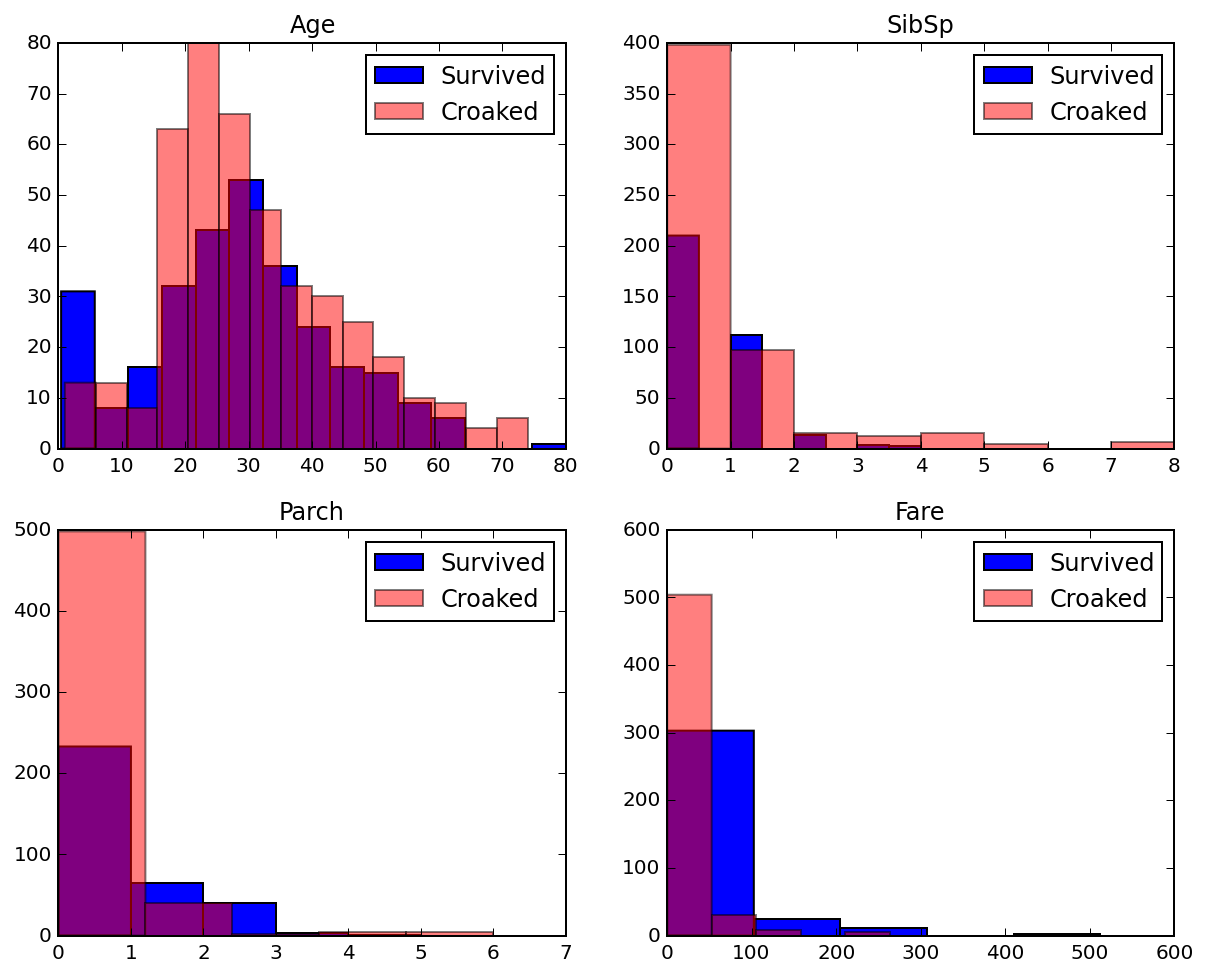

In [3]:
survived = td[td['Survived'] == 1]
croaked = td[td['Survived'] == 0]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, (var, bins) in enumerate([("Age", 15), ("SibSp", 8), ("Parch", 5), ("Fare", 5)]):
    row = i // 2
    col = i % 2
    subplot = ax[row, col]
    subplot.set_title(var)

    # side by side
#     subplot.hist(
#         [survived[var].dropna().values, croaked[var].dropna().values], 
#         bins=bins, label=['Survived', 'Croaked'])

    # overlapping
    subplot.hist(survived[var].dropna().values, bins=bins, color='b', label='Survived')
    subplot.hist(croaked[var].dropna().values, bins=bins, color='r', alpha=0.5, label='Croaked')
    subplot.legend()
None

I notice:
- Young children survive disproportionately
- There may be a correlation between fare and survivorship; those who pay more than the lowest value seem to survive disproportionately
- Those with no family aboard (either childeren via 'Parch' or siblings via 'SibSp') perish disproprotinately

So each of these variables seems worth keeping in our model.

## Re-testing models against richer data

Now that I'm confident adding in the previously skipped variables 'Embarked' and the computed 'Cabin_Sector" could help, I think a good plan is to re-run the same models we tried last time is worth a shot. Here's the updated preprocessor helper function we'll use. Updates since last time:
- We include 'Embarked' and 'Cabin_sector' 
- Since both multiple non-ordinal values, we'll use one-hot encoding to flatten them out into one binary variable for each possible value, e.g embarked becomes embarked_from_C, embarked_from_Q, embarked_from_S
- We can handle missing values by setting the flattened out variable values to 0